Test the hypothesis of whether stock movements of major indices can be modeled by the Gaussian distribution. We will use the Anderson-Darling Test since it gives more weight to the tails. Stocks can be fat tailed, so we need to pay close attention to this when testing for normality.

In [1]:
#get required modules for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import scipy.stats as sci

In [2]:
#read data from csv file obtained from yahoo.com
sp = pd.read_csv("^GSPC.csv",encoding = "utf-8-sig")
dow = pd.read_csv("^DJI.csv",encoding = "utf-8-sig")

In [3]:
#set Date as index and visualize data
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/1950,16.66,16.66,16.66,16.66,16.66,1260000
1,1/4/1950,16.85,16.85,16.85,16.85,16.85,1890000
2,1/5/1950,16.93,16.93,16.93,16.93,16.93,2550000
3,1/6/1950,16.98,16.98,16.98,16.98,16.98,2010000
4,1/9/1950,17.09,17.09,17.08,17.08,17.08,3850000


In [4]:
#iterate over close array and calculate returns
def getreturns(price, column):
    price.insert(loc=len(price.columns),column='Returns',value=0)
    for index, val in price.iterrows():
        if index+1==len(price[column]):
            break
        price.loc[index, 'Returns'] = (m.log(price.loc[index+1,column])-m.log(val.loc[column]))*100
    return price

spx_returns = getreturns(sp,'Close')
dow_returns = getreturns(dow,'Close')

In [5]:
#calculate sample statistics
spx_stats = spx_returns['Returns'].describe()
dow_stats = dow_returns['Returns'].describe()
print("S&P 500")
print(spx_stats)
print("")
print("Dow Jones Industrial Average")
print(dow_stats)

S&P 500
count    17172.000000
mean         0.029369
std          0.965781
min        -22.899729
25%         -0.403902
50%          0.046407
75%          0.494839
max         10.957197
Name: Returns, dtype: float64

Dow Jones Industrial Average
count    8536.000000
mean        0.034413
std         1.100377
min       -25.631511
25%        -0.435571
50%         0.055860
75%         0.557292
max        10.508346
Name: Returns, dtype: float64


As expected, the mean returns are slightly positive. If they were zero or negative, then it would be a zero sum game given the current investing environment. However over the long run (20+ years) people expect the market to give them a positive return. Next, we use a couple of high powered statistical tests to find whether our daily returns are normally distributed with the following hypothesis.

H0 = Data come from a population that is normally distributed
Ha = Data do not come from a population that is normally distributed

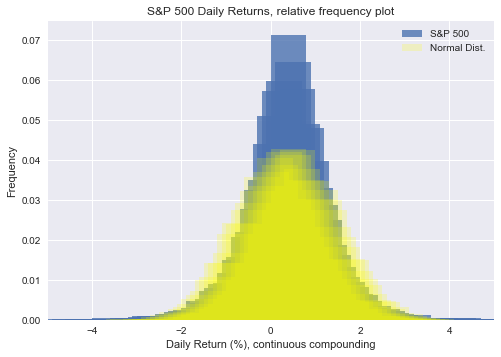

In [10]:
#generate histogram based on sample data
np_spx_returns = np.array(spx_returns['Returns'])
x_low_lim = -5
x_upper_lim = 5
density = spx_returns['Returns'].count()
bins = np.arange(x_low_lim,x_upper_lim,0.1)
hist, edges = np.histogram(np_spx_returns,bins)
#generate histogram based on a normal distribution with loc = sample mean, std = sample std
norm_sample = np.random.normal(spx_returns['Returns'].mean(),spx_returns['Returns'].std(),density)
histnorm, edgesnorm = np.histogram(norm_sample,bins)
freqnorm = histnorm/float(histnorm.sum())
#plt.hist(rel_norm_sample,alpha = 0.5)
freq = hist/float(hist.sum())
plt.bar(bins[:-1],freq,align='edge',alpha=0.8,label='S&P 500')
plt.bar(bins[:-1],freqnorm,align='edge',alpha=0.2,color='yellow',label='Normal Dist.')
plt.style.use('seaborn')
plt.xlim(-5,5)
plt.title('S&P 500 Daily Returns, relative frequency plot')
plt.ylabel('Frequency')
plt.xlabel('Daily Return (%), continuous compounding')
plt.legend(loc='upper right')
plt.show()

Inspection of the histograms of the S&P 500 sample and points generated from a normal distribution with standard deviation equivalent to our sample shows there is more variation close to the mean for the normal distribution than our sample. More of the sample values cluster around the mean, while at the same time the most extreme values far exceed what is expected if the stock movements were normally distributed. Let's quantify this now that we have an idea of it graphically.

In [7]:
pd_norm = pd.DataFrame(norm_sample)
pd_norm_stats = pd_norm.describe()
iqr_sample = float(spx_stats.loc['75%']-spx_stats.loc['25%'])
iqr_norm = float(pd_norm_stats.loc['75%']-pd_norm_stats.loc['25%'])

print('Normal Dist. IQR',round(iqr_norm,3))
print('Sample Dist. IQR',round(iqr_sample,3))


Normal Dist. IQR 1.299
Sample Dist. IQR 0.899


There is indeed more variability close to the mean in the normal distribution, considering the middle 50% of data. Still, the data may be drawn from a normal distribution. Let's run the Anderson-Darling test with alpha = 0.01 to find a conclusion to our hypothesis.

In [8]:
#perform anderson darling test on sample data
sp_norm_test = sci.anderson(spx_returns['Returns'], dist='norm')
dow_norm_test = sci.anderson(dow_returns['Returns'], dist='norm')
indexlist = [['S&P 500',sp_norm_test],['Dow Jones',dow_norm_test]]
for index in indexlist:
    if index[1].statistic > index[1].critical_values[4]:
        print('For the',index[0],', we reject H0 at alpha = 1%, data are not drawn from a normal distribution')
        print('')
        print(index[1])
        print('')
    else:
        print('We fail to reject H0 at alpha = 1% for',index[0], 'data are drawn from a normal distribution')
        print('')
        print(index[1])
        

For the S&P 500 , we reject H0 at alpha = 1%, data are not drawn from a normal distribution

AndersonResult(statistic=254.75077250692266, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

For the Dow Jones , we reject H0 at alpha = 1%, data are not drawn from a normal distribution

AndersonResult(statistic=148.24072777071706, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))



So! We don't seem to have normal distributions of stock movement for the S&P 500 or the DOW. That's very interesting, since the normal distribution is used extensively to model financial instruments, including stocks and options. What can we learn? 

^First, if we are trading these indices, we can expect that at least 50% of the time, the movements are going to be less than what is predicted from the generally accepted models.

^Second, in trading these indices, we are exposed to what are called "Black Swan" events, events that aren't predictable and can really hurt or really help, depending on your position. But empirically speaking, the downside is greater than the upside even if theoretically we not only expect much more restrained movement, but also a price could keep going up and up while zero is our lower limit (no negative prices unless it's your birthday or Christmas). Anyone trading risk defined positions is protected from such events, however naked positions could really do some damage here.

Next steps
*Calculate returns and perform A-D test on a basket of individual stocks to see if we get some sort of aggregation effect when looking at an index, which is a mix of many stocks
*Compare empirical results to a random walk model (a la Random Walk Down Wall Street)
*Utilize other statistical tests to further our case for or against normality. I mean, who wants to be normal, right? So boring... maybe like this analysis is boring... oh no...